<h1>INSTALLING DEPENDENCIES AND READING DATA</h1>

run

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!pip install tensorflow tensorflow-gpu pandas matplotlib sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tensorflow-gpu
  Running setup.py clean for tensorflow-gpu
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2955 sha256=2400edafad73410647694ae71f17500fb85e1112212a9670b2931c2de2d1d41e
  Stored in directory: /root/.cache/pip/wheels/f8/e0/3d/9d0c2020c44a519b9f02ab4fa6d2a4a996c98d79ab2f569fa1
Successfully built sklearn
Failed to build tensorflow-gpu
  error: subprocess-exited-with-error
  
  × Running setup.py install for tensorflow-gpu did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: 

run

In [2]:
import os
os.chdir("/content/drive/My Drive")
import pandas as pd
import tensorflow as tf
import numpy as np

run

In [3]:
df = pd.read_csv(os.path.join('ml projects','toxicity','archive','train.csv' ))

In [ ]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
df.tail()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0
159570,fff46fc426af1f9a,"""\nAnd ... I really don't think you understand...",0,0,0,0,0,0


In [ ]:
df.iloc[1]['comment_text']

"D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)"

<h1>PREPROCESSING DATA</h1>

run all till partitions

In [4]:
from tensorflow.keras.layers import TextVectorization

In [5]:
x = df['comment_text']
y = df[df.columns[2:]].values

In [6]:
MAX_FEATURES = 200000

In [7]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES, output_sequence_length=1800, output_mode='int')
vectorizer.adapt(x.values)

In [8]:
vectorized_text= vectorizer(x.values)

In [9]:
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8)

training, validation and test partitions

In [ ]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [ ]:
train_generator = train.as_numpy_iterator()

<h1>BUILDING THE DEEP NEURAL NETWORK MODEL</h1>

run

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [ ]:
model = Sequential()
model.add(Embedding(MAX_FEATURES+1, 32))
model.add(Bidirectional(LSTM(32, activation = 'tanh')))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(256, activation = 'relu'))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(6, activation = 'sigmoid'))

In [ ]:
model.compile(loss='BinaryCrossentropy', optimizer = 'Adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [ ]:
history = model.fit(train, epochs =1, validation_data=val)

6981/6981 [==============================] - 794s 112ms/step - loss: 0.0630 - val_loss: 0.0469


In [ ]:
from matplotlib import pyplot as plt

<Figure size 576x360 with 0 Axes>

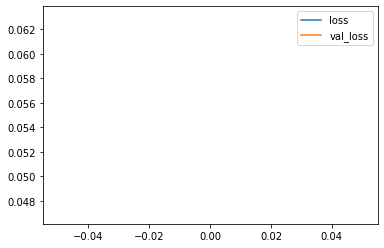

In [ ]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

<h1>MAKING PREDICTIONS</h1>

In [ ]:
input_text = vectorizer('You are a piece of shit!')
batch = test.as_numpy_iterator().next()
batch_x, batch_y = test.as_numpy_iterator().next()
(model.predict(batch_x) >0.5).astype(int)
res = model.predict(np.expand_dims(input_text,0))

NameError: ignored

<h1>EVALUATIONS</h1>

run

In [11]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [ ]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [ ]:
for batch in test.as_numpy_iterator():
  #expanding the batch
  x_true, y_true = batch
  #making prediction
  yhat=model.predict(x_true)
  y_true = y_true.flatten()
  yhat = yhat.flatten()

  pre.update_state(y_true,yhat)
  re.update_state(y_true,yhat)
  acc.update_state(y_true,yhat)


1/1 [==============================] - 0s 53ms/step


In [ ]:
print(f'Precision: {pre.result().numpy()} , Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.8167484402656555 , Recall:0.6727272868156433, Accuracy:0.4663991928100586


<h1>TESTING AND BUILDING THE GRADIO APP</h1>

run

In [12]:
!pip install gradio jinja2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.9/19.9 MB 52.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 9.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.2/294.2 kB 35.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 32.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 18.6 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of mdit-py-plugins to determine which version is compatible with other requirements. This could take a while.
 

run

In [13]:
import gradio as gr

In [ ]:
#model.save('toxicity.h5')

run

In [14]:
model = tf.keras.models.load_model('toxicity.h5')

In [ ]:
input_str = vectorizer('Fuck you!')

In [ ]:
df.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [ ]:
res = model.predict(np.expand_dims(input_str,0))
res>0.5

1/1 [==============================] - 5s 5s/step


array([[ True, False,  True, False,  True, False]])

run

In [15]:
def score_comment(comment):
  vectorized_comment = vectorizer([comment])
  results = model.predict(vectorized_comment)

  text =''
  for idx, col in enumerate(df.columns[2:]):
    text+= '{}: {}\n'.format(col, results[0][idx]>0.5)

  return text

run

In [16]:
interface = gr.Interface(fn= score_comment, inputs = gr.inputs.Textbox(lines = 2, placeholder= 'comment'), outputs='text')

<ipython-input-16-66c99cfe5ba6>:1: GradioDeprecationWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  interface = gr.Interface(fn= score_comment, inputs = gr.inputs.Textbox(lines = 2, placeholder= 'comment'), outputs='text')
<ipython-input-16-66c99cfe5ba6>:1: GradioDeprecationWarning: `optional` parameter is deprecated, and it has no effect
  interface = gr.Interface(fn= score_comment, inputs = gr.inputs.Textbox(lines = 2, placeholder= 'comment'), outputs='text')
<ipython-input-16-66c99cfe5ba6>:1: GradioDeprecationWarning: `numeric` parameter is deprecated, and it has no effect
  interface = gr.Interface(fn= score_comment, inputs = gr.inputs.Textbox(lines = 2, placeholder= 'comment'), outputs='text')


run

In [17]:
interface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://ed8b1c6c8953d70eaf.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
